# Naive representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

In [3]:
# image of the sky filled with double precision complex floats (single precision for reals/imaginaries)
# few pixels are set to relatively large complex random values in random spots (image sources)
# relatively small complex values are added (white noise from background radiations) 

n = 10 #number of antennas

sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
stars = np.random.randint(1, 11) #random number of sources
radius = 1 #np.random.randint(1, 3) #with random radius

for i in range(0, stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-8.42038728e-03-3.4719571e-03j -1.56501345e-02-1.0030005e-02j
   4.70301835e-03+1.7563745e-02j  7.50475144e-03+5.9869722e-03j
  -1.11386389e-03+1.0112015e-02j  4.89772072e+01+6.8351700e+01j
  -5.32045867e-03+6.6767600e-03j  5.31000862e+01+3.3378910e+01j
  -1.49340499e-02-6.6317711e-03j  6.70281099e-03+4.6691499e-03j]
 [-1.20808072e-02-8.6756879e-03j -2.56932853e-03+7.6537058e-03j
   3.10590933e-03-7.9441937e-03j  1.45057477e-02-1.4319804e-02j
   4.47067199e-03+7.9433661e-04j -7.75601948e-03+1.2967494e-02j
   1.78958476e-02-5.9367707e-03j  5.28550148e+01+7.8082436e+01j
  -6.70897728e-03+7.8240794e-04j  8.11430253e-03-4.4714776e-03j]
 [-1.79636676e-03+1.7225474e-02j  6.11728709e-03+2.7127494e-03j
   1.59805138e-02+4.0253997e-03j -4.34439303e-03+1.8911358e-02j
   1.04391379e-02+2.1270229e-02j  1.27908252e-02+2.5063157e-02j
  -6.28213771e-03-1.5821099e-02j -4.32560360e-03-1.1278733e-02j
  -9.08388174e-04-9.7265147e-04j -1.35913352e-02-2.7944758e-03j]
 [-9.71257500e-03+4.9396167e-03j -3.8

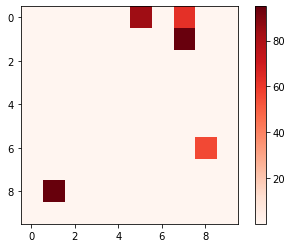

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds') 
cbar = plt.colorbar()

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 304.6664   +191.57466j    -103.47078    -1.6341577j
     8.702567 -150.25797j      36.030293 -171.59529j
   -73.52852   +98.01088j    -195.18623  -170.33682j
   117.15636  +112.201614j   -109.69166  +197.57698j
  -112.09858   +90.435814j    127.12458  -195.63689j   ]
 [ 168.47235  +248.11469j    -117.03143   +62.122017j
    94.37214  -115.38894j     236.28897  -142.8212j
    67.925255 +188.96501j    -269.54865  -200.9207j
    40.88668  -143.61885j     -40.723328  +17.762104j
  -126.92141  +164.15836j     -54.044846  -78.2131j    ]
 [ 142.13449   +81.51722j     -76.030525 +166.48203j
   -27.770205 +123.86627j      96.941795  -66.65501j
   143.13542  +167.76767j     -88.299835 -179.39078j
   185.42438  -145.42645j      41.59298   -13.2657385j
  -198.11638  +113.77307j    -219.44377  -249.09521j   ]
 [  90.68127   +25.893509j   -189.78084   +72.512146j
  -180.55846   +50.25158j      13.174866 -125.77508j
   205.28075  +262.27948j     -76.98833   +84.89893j
    88.784836  -25.206202j   

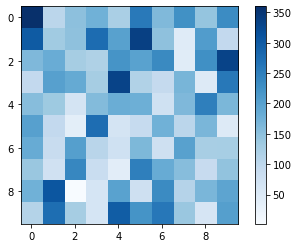

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

In [7]:
sanity = np.fft.ifft2(visibilities).astype('complex64')

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 7.87772e-14
Imaginaries MSE: 1.2075306e-13


In [8]:
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [9]:
# encoding binary data onto qubits
def binary_encode(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [10]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = binary_encode(qc, binary, off_set)

In [11]:
#RUNNING THIS CELL OUTPUTS MEMORY ISSUE

#sim = Aer.get_backend("aer_simulator_matrix_product_state")
#qc_init = qc.copy()
#qc_init.save_statevector()
#statevector = sim.run(qc_init).result().get_statevector()
#plot_bloch_multivector(statevector)

In [12]:
# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 304.6664   +191.57466j    -103.47078    -1.6341577j
     8.702567 -150.25797j      36.030293 -171.59529j
   -73.52852   +98.01088j    -195.18623  -170.33682j
   117.15636  +112.201614j   -109.69166  +197.57698j
  -112.09858   +90.435814j    127.12458  -195.63689j   ]
 [ 168.47235  +248.11469j    -117.03143   +62.122017j
    94.37214  -115.38894j     236.28897  -142.8212j
    67.925255 +188.96501j    -269.54865  -200.9207j
    40.88668  -143.61885j     -40.723328  +17.762104j
  -126.92141  +164.15836j     -54.044846  -78.2131j    ]
 [ 142.13449   +81.51722j     -76.030525 +166.48203j
   -27.770205 +123.86627j      96.941795  -66.65501j
   143.13542  +167.76767j     -88.299835 -179.39078j
   185.42438  -145.42645j      41.59298   -13.2657385j
  -198.11638  +113.77307j    -219.44377  -249.09521j   ]
 [  90.68127   +25.893509j   -189.78084   +72.512146j
  -180.55846   +50.25158j      13.174866 -125.77508j
   205.28075  +262.27948j     -76.98833   +84.89893j
    88.784836  -25.206202j   

In [13]:
fidelity = np.fft.ifft2(readout).astype('complex64')

In [14]:
test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 7.87772e-14
Imaginaries MSE: 1.2075306e-13


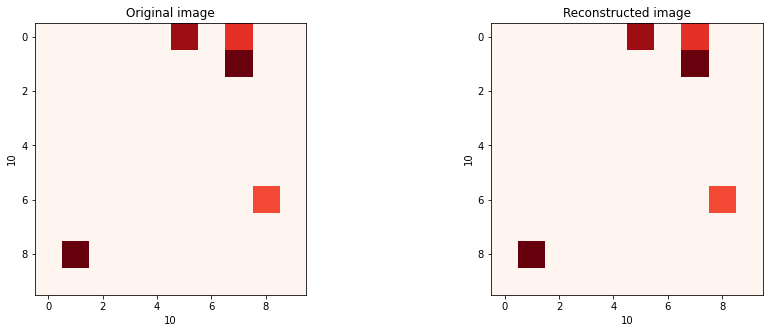

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(sky_image)
modulus2 = np.absolute(fidelity)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Original image")
axs[1].set_title("Reconstructed image")

for ax in axs.flat:
    ax.set(xlabel=n, ylabel=n)